<a href="https://colab.research.google.com/github/kimberley-faria/learning_based_img_compression/blob/texture-recognition-baseline/Pytorch_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization / Install packages

In [ ]:
!cp -r drive/MyDrive/696DS/* .

In [ ]:
!pip install compressai pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 13.1 MB/s eta 0:00:00


# CompressAI Module

## Modify forward function of pretrained model to get y_hat and scales_hat


In [ ]:
import torch
import torch.nn.functional as F
from compressai.models import ScaleHyperprior
from compressai.zoo import bmshj2018_hyperprior

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class VAE_hyperprior(ScaleHyperprior):
    def __init__(self, N, M, **kwargs):
        super().__init__(N, M, **kwargs)
        
    def forward(self, x):
        y = self.g_a(x)
        z = self.h_a(torch.abs(y))
        z_hat, z_likelihoods = self.entropy_bottleneck(z)
        scales_hat = self.h_s(z_hat)
        y_hat, y_likelihoods = self.gaussian_conditional(y, scales_hat)
        x_hat = self.g_s(y_hat)

        return {
            "x_hat": x_hat,
            "y_hat": y_hat,
            "z_hat": z_hat,
            "scales_hat": scales_hat,
            "likelihoods": {"y": y_likelihoods, "z": z_likelihoods},
        }

In [ ]:
# https://github.com/InterDigitalInc/CompressAI/blob/ee91d536bd934fc1f8b1532f78db4c94072ae26d/compressai/zoo/image.py#L262:~:text=%7D%2C-,%22bmshj2018%2Dhyperprior%22%3A%20%7B,-1%3A%20(128
# "bmshj2018-hyperprior": {
#         1: (128, 192),
#         2: (128, 192),
#         3: (128, 192),
#         4: (128, 192),
#         5: (128, 192),
#         6: (192, 320),
#         7: (192, 320),
#         8: (192, 320),
#     },

model = VAE_hyperprior(128, 192)
# if you need pretrained weights
model.load_state_dict(bmshj2018_hyperprior(quality=1, pretrained=True).state_dict())

Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-hyperprior-1-7eb97409.pth.tar" to /root/.cache/torch/hub/checkpoints/bmshj2018-hyperprior-1-7eb97409.pth.tar


  0%|          | 0.00/20.2M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
net = model.eval().to(device)

In [ ]:
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 5075843


## Load and pad image


In [ ]:
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt

In [ ]:
# img = Image.open('./stmalo_fracape.png').convert('RGB')
# x = transforms.ToTensor()(img).unsqueeze(0).to(device)
# x.shape
# # Must be a multiple of N*M

In [ ]:
img = Image.open('./brick_000031.jpg').convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)
print("Original size:", x.shape)

# x = F.pad(input=x, pad=(0, 22, 0, 22), mode='constant', value=0)
x = F.pad(input=x, pad=(0, 150, 0, 150), mode='constant', value=0) # 32 x 32 size images
# x = F.pad(input=x, pad=(0, 86, 0, 86), mode='constant', value=0)
print("After padding:", x.shape)
# Must be a multiple of N*M

Original size: torch.Size([1, 3, 362, 362])
After padding: torch.Size([1, 3, 512, 512])


In [ ]:
# img = Image.open('./oranges.jpg').convert('RGB')
# x = transforms.ToTensor()(img).unsqueeze(0).to(device)
# print("Original size:", x.shape)

# x = F.pad(input=x, pad=(0, 0, 0, 64), mode='constant', value=0)
# print("After padding:", x.shape)

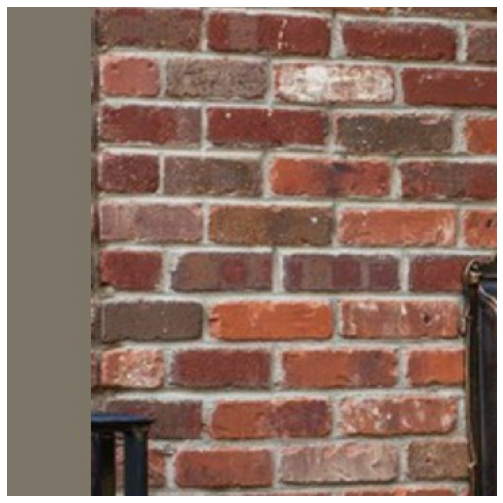

In [ ]:
%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()

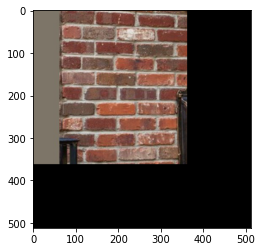

In [ ]:
plt.imshow(x.cpu().squeeze().permute(1, 2, 0))

## Run image through forward pass

In [ ]:
with torch.no_grad():
    outputs = net.compress(x)

In [ ]:
with torch.no_grad():
    out_net = net.forward(x)
out_net['x_hat'].clamp_(0, 1)
print(out_net.keys())

dict_keys(['x_hat', 'y_hat', 'z_hat', 'scales_hat', 'likelihoods'])


In [ ]:
out_net.keys()

dict_keys(['x_hat', 'y_hat', 'z_hat', 'scales_hat', 'likelihoods'])

## Visualize

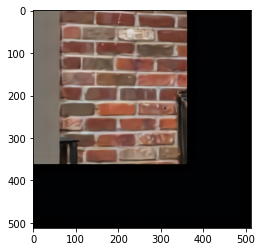

In [ ]:
plt.imshow(out_net["x_hat"].squeeze().permute(1, 2, 0).cpu())

In [ ]:
out_net["x_hat"].shape, out_net["y_hat"].shape, out_net["z_hat"].shape, out_net["scales_hat"].shape

(torch.Size([1, 3, 512, 512]),
 torch.Size([1, 192, 32, 32]),
 torch.Size([1, 128, 8, 8]),
 torch.Size([1, 192, 32, 32]))

In [ ]:
out_net["likelihoods"]["y"].shape, out_net["likelihoods"]["z"].shape

(torch.Size([1, 192, 32, 32]), torch.Size([1, 128, 8, 8]))

In [ ]:
out_net["y_hat"]

tensor([[[[0., -0., -0.,  ..., 0., 0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          ...,
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.]],

         [[-0., -0., -0.,  ..., 0., 0., 0.],
          [-0., -0., 0.,  ..., 0., 0., 0.],
          [-0., -0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., -0., 0.,  ..., 0., 0., 0.],
          [0., -0., 0.,  ..., 0., 0., 0.],
          [0., -0., -0.,  ..., -0., -0., -0.]],

         [[-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., 0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          ...,
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., 0.]],

         ...,

         [[0., 0., -0.,  ..., 0., 0., 0.],
          [0., -0., 0.,  ..., -0., -0., 0.],
         

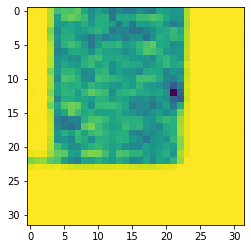

In [ ]:
plt.imshow(out_net["likelihoods"]["y"].squeeze().sum(axis=0).cpu())

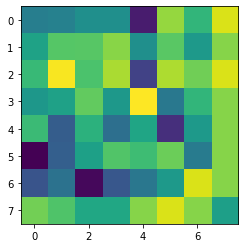

In [ ]:
plt.imshow(out_net["likelihoods"]["z"].squeeze().sum(axis=0).cpu())

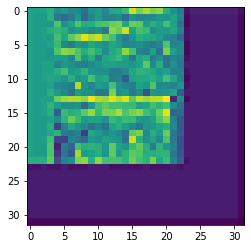

In [ ]:
plt.imshow(out_net["y_hat"].squeeze().sum(axis=0).cpu())

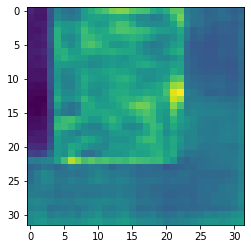

In [ ]:
plt.imshow(out_net["scales_hat"].squeeze().sum(axis=0).cpu())

In [ ]:
y_hat = out_net["y_hat"]
y_hat.T.shape

<ipython-input-26-8369720fc9d6>:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  y_hat.T.shape


torch.Size([32, 32, 192, 1])

In [ ]:
scales_hat = out_net["scales_hat"]
scales_hat.T.shape

torch.Size([32, 32, 192, 1])

# cResnet-39 Module

## Pytorch Lightning

In [ ]:
import torchvision.models as models
from torchvision.models.resnet import Bottleneck
import pytorch_lightning as pl
import torch.nn as nn

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
# 1x1 convolution
def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                     stride=stride, bias=False)

# Residual block
class ResidualBlock(nn.Module):
   
    #  (0): Bottleneck(
    #     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    #     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    #     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    #     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    #     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    #     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    #     (relu): ReLU(inplace=True)
    #     (downsample): Sequential(
    #       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    #       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    #     )
    #   ) 


    #   (0): ResidualBlock(
    #     (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    #     (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    #     (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    #     (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    #     (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    #     (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    #     (relu): ReLU(inplace=True)
    #     (downsample): Sequential(
    #     (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    #     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    #     )
    # )


    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv1x1(in_channels, in_channels, stride)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = conv3x3(in_channels, in_channels)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv3 = conv1x1(in_channels, out_channels, stride)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        # x = x.to(device)
        print(x.shape)
        residual = x
        out = self.conv1(x)
        # print(out.shape)
        out = self.bn1(out)
        # print(out.shape)
        out = self.relu(out)
        # print(out.shape)
        out = self.conv2(out)
        # print(out.shape)
        out = self.bn2(out)
        # print(out.shape)
        out = self.relu(out)
        # print(out.shape)
        out = self.conv3(out)
        # print(out.shape)
        out = self.bn3(out)
        # print(out.shape)
        if self.downsample:
            # print("downsample x")
            residual = self.downsample(x)
        # print(residual.shape)
        out += residual
        out = self.relu(out)
        return out

class cResnet39(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # init a pretrained resnet
        backbone = models.resnet50(weights="DEFAULT")
        layers = nn.ModuleList(list(backbone.children())[5:-1])

        self.in_channels = 32
        self.layer1_y_hat = self.make_layer(ResidualBlock, 128, 1)

        self.in_channels = 32
        self.layer1_scales_hat = self.make_layer(ResidualBlock, 128, 1)

        self.feature_extractor = nn.Sequential(*layers)

        # # use the pretrained model to classify cifar-10 (10 image classes)
        num_target_classes = 23
        self.classifier = nn.Linear(2048*128, 23)

    def make_layer(self, block, out_channels, blocks, stride=1):

        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv1x1(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = nn.ModuleList()
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        print(*layers)
        return nn.Sequential(*layers)

    def forward(self, y_hat, scales_hat):
        y_hat = self.layer1_y_hat(y_hat)
        scales_hat = self.layer1_scales_hat(scales_hat)

        print(y_hat.shape, scales_hat.shape)

        x = torch.concat((y_hat, scales_hat))

        print(x.shape)
        x =torch.reshape(x, (128, 256, -1, 1))
        print(x.shape)

        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)

        print(representations.shape)

        x = self.classifier(representations.reshape((-1,)))

        print(x.shape)

        print(x)

        return x
        

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, target = batch
        # x, target = x.to(device), target.to(device)
        print(x.shape)

        with torch.no_grad():
            out_net = net.forward(x)

        y_hat, scales_hat = out_net["y_hat"].to(device), out_net["scales_hat"].to(device)

        y_hat, scales_hat = y_hat.to(device), scales_hat.to(device)

        predict = self.forward(y_hat.T, scales_hat.T)
        predict = torch.unsqueeze(predict, 0)
        print(predict.shape)
        print(target.shape)
        loss = F.cross_entropy(predict, target)
        # Logging to TensorBoard (if installed) by default
        # self.log("train_loss", loss)
        print("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
model = cResnet39()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResidualBlock(
  (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
ResidualBlock(
  (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [ ]:

# model = model.to(device)
# y_hat = y_hat.to(device)
# scales_hat = scales_hat.to(device)
# model(y_hat.T, scales_hat.T)

In [ ]:
for child in model.children():
    print(child)
    print("="*50)

Sequential(
  (0): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)
Sequential(
  (0): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2)

## nn.Module implementation (ignore)

In [ ]:
# import torch
# from torchvision.models import resnet50
# from torchvision.models.resnet import Bottleneck, ResNet
# import torch.nn as nn

In [ ]:
# model = resnet50(pretrained=True)
# model.children()

# for child in model.children():
#     print(child)
#     print("="*50)

In [ ]:

# newmodel = torch.nn.Sequential(*(list(model.children())[5:]))
# print(newmodel)

# for child in newmodel.children():
#     print(child)
#     print("="*50)

In [ ]:
# class cResNet39(ResNet):
#     def __init__(self, block, layers, **kwargs):
#         super().__init__(block, layers, **kwargs)
#         self.layer1_y_hat = self._make_layer(block, 32, 1)
#         self.layer1_scales_hat = self._make_layer(block, 32, 1)
        
#     def forward(self, y_hat, scales_hat):
#         # x = self.conv1(x)
#         # x = self.bn1(x)
#         # x = self.relu(x)
#         # x = self.maxpool(x)

#         # x = self.layer1(x)

#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)

#         return x

In [ ]:
# net = cResNet39(Bottleneck, [3, 4, 6, 3])

# for child in net.children():
#     print(child)
#     print("="*50)

# Data loading

In [ ]:
!ls -la

total 116
drwxr-xr-x 1 root root  4096 Mar 20 17:22 .
drwxr-xr-x 1 root root  4096 Mar 20 17:19 ..
-rw------- 1 root root 21061 Mar 20 17:22 bmshj2018.py
-rw------- 1 root root 36386 Mar 20 17:22 brick_000031.jpg
drwxr-xr-x 4 root root  4096 Mar 17 13:39 .config
drwx------ 7 root root  4096 Mar 20 17:22 drive
drwx------ 4 root root  4096 Mar 20 17:22 minc-mini
-rw------- 1 root root 13795 Mar 20 17:22 oranges.jpg
drwxr-xr-x 1 root root  4096 Mar 17 13:40 sample_data
-rw------- 1 root root 13698 Mar 20 17:22 tfci.py


https://github.com/zhanghang1989/PyTorch-Encoding/blob/master/encoding/datasets/minc.py

In [ ]:
import os
from PIL import Image

import torch
import torch.utils.data as data

class MINCDataset(data.Dataset):
    NUM_CLASS = 5
    def __init__(self, root=os.path.expanduser('.'),
                 train=True, transform=None, download=None):
        split='train' if train == True else 'val'
        root = os.path.join(root, 'minc-mini')
        print(root)
        self.transform = transform
        classes, class_to_idx = find_classes(root + '/images')
        if split=='train':
            filename = os.path.join(root, 'labels/train1.txt')
        else:
            filename = os.path.join(root, 'labels/validate1.txt')

        self.images, self.labels = make_dataset(filename, root, 
            class_to_idx)
        assert (len(self.images) == len(self.labels))

    def __getitem__(self, index):
        _img = Image.open(self.images[index]).convert('RGB')
        _label = self.labels[index]
        if self.transform is not None:
            _img = self.transform(_img)
            _img = F.pad(input=_img, pad=(0, 150, 0, 150), mode='constant', value=0)

        return _img, _label

    def __len__(self):
        return len(self.images)

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(filename, datadir, class_to_idx):
    images = []
    labels = []
    with open(os.path.join(filename), "r") as lines:
        for line in lines:
            _image = os.path.join(datadir, line.rstrip('\n'))
            _dirname = os.path.split(os.path.dirname(_image))[1]
            assert os.path.isfile(_image)
            label = class_to_idx[_dirname]
            images.append(_image)
            labels.append(label)

    return images, labels

./minc-mini
0
0
0
1
1
1
2
2
2
3
3
3
4
4
4


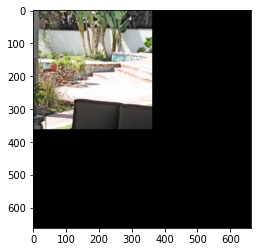

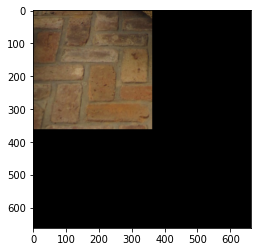

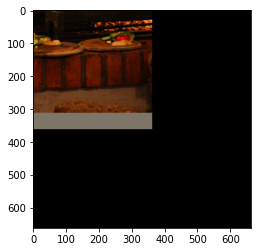

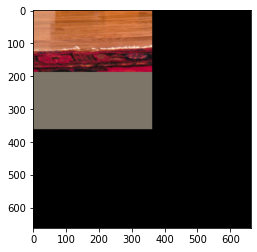

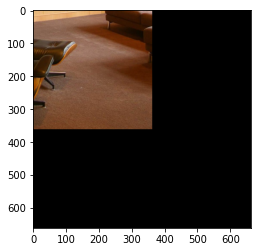

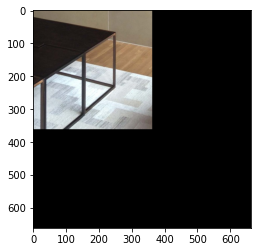

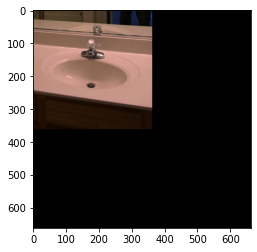

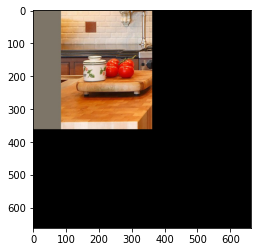

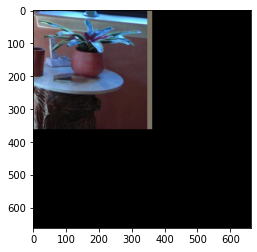

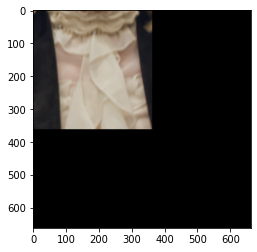

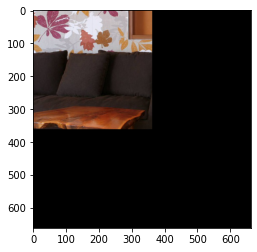

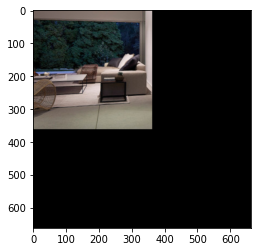

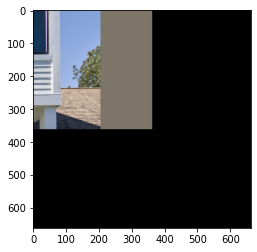

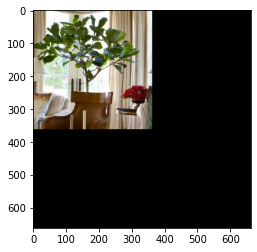

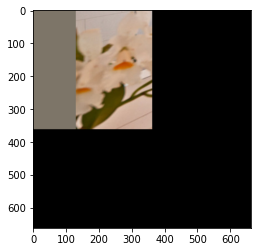

In [ ]:
minc_mini = MINCDataset(transform=transforms.ToTensor())

for x, label in minc_mini:
    print(label)
    x = F.pad(input=x, pad=(0, 150, 0, 150), mode='constant', value=0) # 32 x 32 size images
    plt.figure()
    plt.imshow(x.squeeze().permute(1, 2, 0))
    


# Finetune cResnet-39

In [ ]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor

model = cResnet39()
model = model.to(device)

minc_mini = MINCDataset(transform=ToTensor())
train_loader = utils.data.DataLoader(minc_mini)

trainer = pl.Trainer(limit_train_batches=1, max_epochs=1)
trainer.fit(model=model, train_dataloaders=train_loader)


ResidualBlock(
  (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
ResidualBlock(
  (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

/usr/local/lib/python3.9/dist-packages/lightning_fabric/accelerators/cuda.py:235: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type       | Params
-------------------------------------------------
0 | layer1_y_hat      | Sequential | 19.1 K
1 | layer1_scales_hat | Sequential | 19.1 K
2 | feature_extractor | 

Training: 0it [00:00, ?it/s]

torch.Size([1, 3, 512, 512])
torch.Size([32, 32, 192, 1])
torch.Size([32, 32, 192, 1])
torch.Size([32, 128, 192, 1]) torch.Size([32, 128, 192, 1])
torch.Size([64, 128, 192, 1])
torch.Size([128, 256, 48, 1])
torch.Size([128, 2048])
torch.Size([23])
tensor([ 0.4547,  0.7472, -0.1085, -0.4269,  0.1119, -0.0666, -0.4080, -0.3005,
        -0.0949,  0.2114,  0.0749,  0.1442, -0.2269,  0.3416, -0.3185, -0.4874,
         0.5132,  0.4557, -0.1380,  0.1405, -0.0031, -0.3642, -0.1030],
       grad_fn=<AddBackward0>)
torch.Size([1, 23])
torch.Size([1])
train_loss tensor(2.7433, grad_fn=<NllLossBackward0>)


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
